# Optimizing vehicle delivery optimization 

This is a Proof of Concept that applying Reinforcement Learning (RL) to solve the classical vehícle routing problem could potentially help our customer Oktank to optimize the delivery of its products and generate savings through the use of sagemaker capabilities and pre-loaded machine learning algorythms.

Having the model defined, customer data will be fed into the model this way we can measure the pòtential gain with this model. 

# Problem Statement

Consider a delivery driver using a phone app, orders arrive on the app in a dynamic manner. Each order has a delivery charge known to the driver at the time of order creation, and it is assigned to a location in the country(Mexico). The country is a grid map and consists of mutually exclusive zones that generate orders at different rates and rewards. The orders have a delivery time limit, the timer starts with the order creation and is same for all orders. The driver has to accept an order and pick up the cars from a given location prior to delivery. The truck has a capacity limit of 13, but the driver can accept unlimited orders and plan their route accordingly. The driver’s goal is to maximize the total net reward.

This formulation is known as stochastic and dynamic capacitated vehicle routing problem with pickup and delivery, time windows and service guarantee.

<img src="images/Model.png" width="500" align="center"/>

At each time step, the RL agent is aware of the following information:

    Pickup location
    Driver info: driver's location, capacity left
    Order info: order's location, order's status (open, accepted, picked up or delivered), time elapsed since each order’s generation, order dollar value

At each time step, the RL agent can take one of the following actions:

    Accept an order
    Pick up an accepted order
    Go to a dealer's node for delivery
    Head to a specific pickup location
    Wait and stay unmoved

During training, the agent cannot perform the following invalid actions: (i) pick up an order when its remaining capacity is 0; (ii) pick up an order that is not yet accepted; (iii) deliver an order that is not yet picked up.

At each time step, the reward is defined as the difference between total value of all delivered orders and cost:

    Total value of all delivered orders is divided into 3 equal parts -- when the order gets accepted, picked up, and delivered respectively
    Cost includes time cost and moving cost. Both are per time step
    A large penalty is imposed if the agent accepts an order but fails to deliver within the delivery limit



## Using Amazon SageMaker for RL

Amazon SageMaker allows you to train your RL agents in cloud machines using docker containers. You do not have to worry about setting up your machines with the RL toolkits and deep learning frameworks. You can easily switch between many different machines setup for you, including powerful GPU machines that give a big speedup. You can also choose to use multiple machines in a cluster to further speedup training, often necessary for production level loads.

## Pre-requisites

In [113]:
import sagemaker
import boto3
import sys
import os
import glob
import re
import subprocess
from IPython.display import HTML
import time
from time import gmtime, strftime
sys.path.append("common")
from misc import get_execution_role, wait_for_s3_object
from sagemaker.rl import RLEstimator, RLToolkit, RLFramework

### Setup S3 bucket

Set up the linkage and authentication to the S3 bucket that you want to use for checkpoint and the metadata.

In [114]:
# S3 bucket
sage_session = sagemaker.session.Session()
s3_bucket = "vrp-" + sage_session.default_bucket()
s3_output_path = 's3://{}/'.format(s3_bucket)
print("S3 bucket path: {}".format(s3_output_path))

S3 bucket path: s3://vrp-sagemaker-us-east-1-062241367565/


## Define Variables

We define variables such as the job prefix for the training jobs.

In [115]:
# create unique job name 
job_name_prefix = 'vrp-oktank-logistics'

In [116]:
#Going with sagemaker mode, local present just for debugging.
local_mode = False

if local_mode:
    instance_type = 'local'
else:
    # Pick the instance type used for trainning the model
    instance_type = "ml.m5.4xlarge"

### IAM role

In [117]:
#Get the local role for invoking other AWS Services, such as S3 where the metadata will live.
try:
    role = sagemaker.get_execution_role()
except:
    role = get_execution_role()

# Display the current role.
print("Using IAM role arn: {}".format(role))

Using IAM role arn: arn:aws:iam::062241367565:role/service-role/AmazonSageMaker-ExecutionRole-20191017T154121


## Set up the environment

The environment is defined in a Python file called src/vrp_env.py and the file is uploaded on /src directory.

The environment also implements the init(), step() and reset() functions that describe how the environment behaves. This is consistent with Open AI Gym interfaces for defining an environment.

1. init() - initialize the environment in a pre-defined state
2.    step() - take an action on the environment
3.    reset()- restart the environment on a new episode
4.    render() - get a rendered image of the environment in its current state



In [118]:
#!pygmentize src/vrp_env.py

## Write the training code

The training code is written in the file `train_vehicle_routing_problem.py` which is also uploaded in the /src directory. First we import the environment files and the preset files, and then define the main() function.


In [119]:
#!pygmentize src/train_vehicle_routing_problem.py

## Train the RL model using the Python SDK Script mode

If you are using local mode, the training will run on the notebook instance. 
When using SageMaker for training, we can select a GPU instance.

1. Specify the source directory where the gym environment and training code is uploaded (S3 Bucket defined above)
2. Specify the entry point as the training code, the code we just went through above.
3. Specify the choice of RL toolkit and framework. 
4. Define the training parameters such as the instance count, job name, S3 path for output and job name. 
5. Specify the hyperparameters for the RL agent algorithm.
6. Define the metrics definitions that we are interested in capturing in your logs (Cloudwatch).

In [120]:
metric_definitions = [{'Name': 'episode_reward_mean',
  'Regex': 'episode_reward_mean: ([-+]?[0-9]*\\.?[0-9]+([eE][-+]?[0-9]+)?)'},
 {'Name': 'episode_reward_max',
  'Regex': 'episode_reward_max: ([-+]?[0-9]*\\.?[0-9]+([eE][-+]?[0-9]+)?)'},
 {'Name': 'episode_reward_min',
  'Regex': 'episode_reward_min: ([-+]?[0-9]*\\.?[0-9]+([eE][-+]?[0-9]+)?)'}]

In [121]:
train_entry_point = "train_vehicle_routing_problem.py"

#How long we want to the train this model for
train_job_max_duration_in_seconds = 60 * 15

estimator = RLEstimator(entry_point= train_entry_point,
                        source_dir="src",
                        dependencies=["common/sagemaker_rl"],
                        toolkit=RLToolkit.RAY,
                        toolkit_version='0.6.5',
                        framework=RLFramework.TENSORFLOW,
                        role=role,
                        train_instance_type=instance_type,
                        train_instance_count=4,
                        output_path=s3_output_path,
                        base_job_name=job_name_prefix,
                        metric_definitions=metric_definitions,
                        train_max_run=train_job_max_duration_in_seconds,
                        hyperparameters={}
                       )

In [122]:
#Calling .fit() method will start the model trainning
estimator.fit(wait=local_mode)
rl_job_name = estimator.latest_training_job.job_name
print("Training job: %s" % rl_job_name)

Training job: vrp-oktank-logistics-2019-12-12-22-50-04-150


In [123]:
#Visualize the trainning progress through intermediate folder creation
s3_url = "s3://{}/{}".format(s3_bucket,rl_job_name)

intermediate_folder_key = "{}/output/intermediate/".format(rl_job_name)
intermediate_url = "s3://{}/{}training/".format(s3_bucket, intermediate_folder_key)

print("S3 job path: {}".format(s3_url))
print("Intermediate folder path: {}".format(intermediate_url))

S3 job path: s3://vrp-sagemaker-us-east-1-062241367565/vrp-oktank-logistics-2019-12-12-22-50-04-150
Intermediate folder path: s3://vrp-sagemaker-us-east-1-062241367565/vrp-oktank-logistics-2019-12-12-22-50-04-150/output/intermediate/training/


# Ploting the metrics for the trainning:
It's important to notice that sage maker provides an analytic functions so we can use this data to see the model performance overtime.
Below we see the reward over time and how it increases

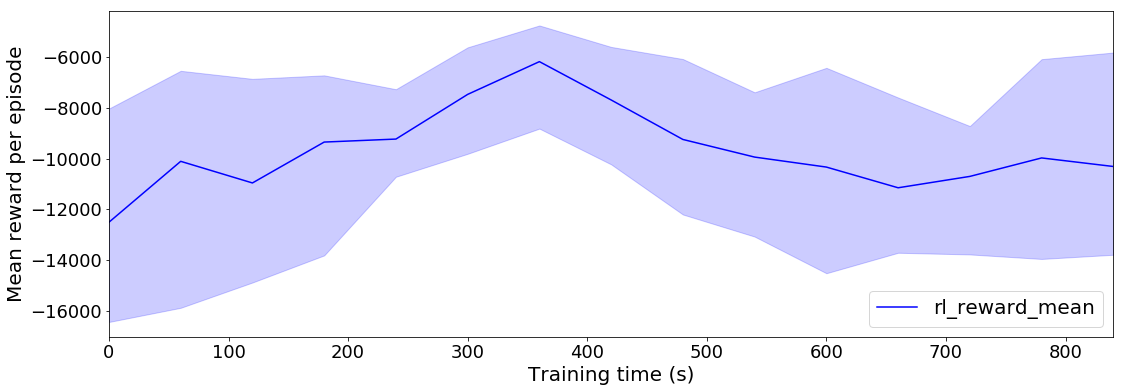

In [125]:
%matplotlib inline
from sagemaker.analytics import TrainingJobAnalytics

if not local_mode:
    df = TrainingJobAnalytics(rl_job_name, ['episode_reward_mean']).dataframe()
    df_min = TrainingJobAnalytics(rl_job_name, ['episode_reward_min']).dataframe()
    df_max = TrainingJobAnalytics(rl_job_name, ['episode_reward_max']).dataframe()
    df['rl_reward_mean'] = df['value']
    df['rl_reward_min'] = df_min['value']
    df['rl_reward_max'] = df_max['value']
    num_metrics = len(df)

    if num_metrics == 0:
        print("No algorithm metrics found in CloudWatch")
    else:
        plt = df.plot(x='timestamp', y=['rl_reward_mean'], figsize=(18,6), fontsize=18, legend=True, style='-', color=['b','r','g'])
        plt.fill_between(df.timestamp, df.rl_reward_min, df.rl_reward_max, color='b', alpha=0.2)
        plt.set_ylabel('Mean reward per episode', fontsize=20)
        plt.set_xlabel('Training time (s)', fontsize=20)
        plt.legend(loc=4, prop={'size': 20})
else:
    print("Can't plot metrics in local mode.")